In [4]:
import os
import sys
import json
import time
import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import re
import pickle
#import itertools
import PIL
import PIL.Image

In [5]:
IPDIR_IMGS = r'/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/'

In [11]:
IPDIR_WEIGHTS = r'/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCap/SavedData/Thesis_ImgCap_Weights_In_Run2/'

#                    Model Training Parameters
## LR_1 = 0.0002
## BATCH_SIZE_1 = 128   ## how many images per batch
## N_EPOCHS_1 = 5
## Adam optimizer

#                    Data
## 97k of Train2017 (no validation set used)

#                    Model definition parameters
## EMBEDDING_DIMS = 200
## VOCAB_SIZE = 6761   (Threshold freq = 10 to make VOCAB_THRESHOLD)
## MAX_LENGTH_CAPTION = 49

#                    Epoch training Losses
## Epoch 1 started at 12:34:31
## LR used = 0.00019999999494757503 
## 757/757 [==============================] - 5051s 7s/step - loss: 4.9100
## Epoch 2 started at 13:58:54
## LR used = 0.00019999999494757503 
## 757/757 [==============================] - 5074s 7s/step - loss: 3.8901
## Epoch 3 started at 15:23:35
## LR used = 0.00019999999494757503 
## 757/757 [==============================] - 5080s 7s/step - loss: 3.6190
## Epoch 4 started at 16:48:23
## LR used = 0.00019999999494757503 
## 757/757 [==============================] - 5097s 7s/step - loss: 3.4708
## Epoch 5 started at 18:13:26
## LR used = 0.00019999999494757503 
## 757/757 [==============================] - 5129s 7s/step - loss: 3.3735


In [12]:
WEIGHTS_FILE = r'Decoder_Run_2_Wt_ep_10.h5'

In [13]:
SAVED_WEIGHTS_PATH = IPDIR_WEIGHTS + WEIGHTS_FILE
SAVED_WEIGHTS_PATH

'/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCap/SavedData/Thesis_ImgCap_Weights_In_Run2/Decoder_Run_2_Wt_ep_10.h5'

In [14]:
print(f"Exists = {os.path.exists(IPDIR_WEIGHTS + WEIGHTS_FILE)}\t\tIsfile = {os.path.isfile(IPDIR_WEIGHTS + WEIGHTS_FILE)}")

Exists = True		Isfile = True


## Create the CNN Encoder pre-trained

In [15]:
## Make images suitable for use by Inception-v3 model later
##
## Resize to (299, 299)
## As model needs 4-dim input tensor, add one dimenion to make it (1, 299, 299, 3)
## Preprocess the image using custom function of Inception-v3 model

def preprocess_image_for_Incepv3(_img_path, _key = 'DUMMY', _DEBUG=False):
    img = tf.keras.preprocessing.image.load_img(_img_path, target_size=(299, 299))
    #print(f"type={type(img)}") # type(img): type=<class 'PIL.Image.Image'>
    if _DEBUG:
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.imshow(img)
        plt.title('Original Image(Resized): ' + _key + '.jpg')
    img = tf.keras.preprocessing.image.img_to_array(img) # Converts PIL Image instance to numpy array (299,299,3)
    img = np.expand_dims(img, axis=0) #Add one more dimension: (1, 299, 299, 3) # Inception-V3 requires 4 dimensions
    img = tf.keras.applications.inception_v3.preprocess_input(img) # preprocess image as per Inception-V3 model
    if _DEBUG:
        plt.subplot(122)
        plt.imshow(img[0])
        plt.title('Preprocessed image for Inception-V3: ' + _key + '.jpg')
    return img  # shape will be (1, 299, 299, 3)

In [16]:
# Function to encode given image into a vector of size (2048, )
def encode_image(_imgpath, _key = 'DUMMY', _DEBUG=False):
    preproc_img = preprocess_image_for_Incepv3(_imgpath, _key = 'DUMMY', _DEBUG=False) # preprocess image per Inception-v3 requirements
    encoded_features = model_CNN_encoder.predict(preproc_img) # Get encoding vector for image
    encoded_features = encoded_features.reshape(encoded_features.shape[1], ) # reshape from (1, 2048) to (2048, )
    return encoded_features

In [17]:

### Load pre-trained model of Inception-v3 pretrained on Imagenet
### Then, Encode images into feature vectors and save it to disk
###
### Doing this in advance so that the feature vector representation of images is already available. Will drastically speed up training

# Load Inception-V3 model
model_inception_v3_pretrained_imagement = tf.keras.applications.InceptionV3(weights='imagenet')

# Create new model, by removing last layer (output layer) from Inception-V3
model_CNN_encoder = keras.Model(inputs=model_inception_v3_pretrained_imagement.input, outputs=model_inception_v3_pretrained_imagement.layers[-2].output)

type(model_CNN_encoder) ## should be tensorflow.python.keras.engine.functional.Functional

tensorflow.python.keras.engine.training.Model

## Reload the wordtoix and ixtoword lists for inferernce use

In [18]:
I2W_FILE = r'/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCap/SavedData/run2_1_kagg/ixtoword_train_97000.pkl'
W2I_FILE = r'/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCap/SavedData/run2_1_kagg/wordtoix_train_97000.pkl'

with open(I2W_FILE, 'rb') as handle:
    ixtoword = pickle.load(handle)

with open(W2I_FILE, 'rb') as handle:
    wordtoix = pickle.load(handle)

print(f"Check wordtoix entries ::\nstartseq = {wordtoix.get('startseq')}\tendseq = {wordtoix.get('endseq')}\tbird = {wordtoix.get('bird')}")
print(f"Check ixtoword entries ::\nix 1 = {ixtoword.get('1')}\tix 10 = {ixtoword.get('10')}\tix 1362 = {ixtoword.get('1362')}")

Check wordtoix entries ::
startseq = 1	endseq = 9	bird = 974
Check ixtoword entries ::
ix 1 = None	ix 10 = None	ix 1362 = None


## Reload Decoder model

In [19]:
def reload_rnn_encoder_saved_weights(_saved_weights_file, _EMBEDDING_DIMS, _VOCAB_SIZE, _MAX_LENGTH_CAPTION):
    if os.path.exists(_saved_weights_file) and os.path.isfile(_saved_weights_file):
        ## Decoder Model defining
        
        ## parameters to define model
        #EMBEDDING_DIMS is initialised earlier while creating embedding matrix
        #VOCAB_SIZE is initialised earlier
        #MAX_LENGTH_CAPTION is initialised earlier
        
        inputs1 = keras.Input(shape=(2048,))
        fe1 = keras.layers.Dropout(0.5)(inputs1)
        fe2 = keras.layers.Dense(256, activation='relu')(fe1)
        
        # partial caption sequence model
        inputs2 = keras.Input(shape=(_MAX_LENGTH_CAPTION,))
        se1 = keras.layers.Embedding(_VOCAB_SIZE, _EMBEDDING_DIMS, mask_zero=True)(inputs2)
        se2 = keras.layers.Dropout(0.5)(se1)
        se3 = keras.layers.LSTM(256)(se2)
        
        # decoder (feed forward) model
        decoder1 = keras.layers.add([fe2, se3])
        decoder2 = keras.layers.Dense(256, activation='relu')(decoder1)
        outputs = keras.layers.Dense(_VOCAB_SIZE, activation='softmax')(decoder2)
        
        # merge the two input models
        reloaded_rnn_decoder_model = keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
        
        print(f"\nRNN Decoder model defined with these paramenters:\nEMBEDDING_DIMS = {_EMBEDDING_DIMS} , VOCAB_SIZE = {_VOCAB_SIZE} , MAX_LENGTH_CAPTION = {_MAX_LENGTH_CAPTION}\nAttempting to load weights...")
        
        ## load the weights
        reloaded_rnn_decoder_model.load_weights(_saved_weights_file)
        print(f"SUCCESS - Reloaded weights from :: {_saved_weights_file}")
        return reloaded_rnn_decoder_model
    else:
        print(f"\nERROR reloading weights. Check weights file exists here = {_saved_weights_file} ;\nOR model setup parameters incompatible with the saved weights file given.")
        return None

def greedySearch(_decoder_model, _img_encoding, _max_length, _wordtoix = None, _ixtoword = None):
    wordtoix = _wordtoix
    ixtoword = _ixtoword
    in_text = 'startseq'
    for i in range(_max_length):
        sequence = [ wordtoix[w] for w in in_text.split() if w in wordtoix ]
        sequence = keras.preprocessing.sequence.pad_sequences([sequence], maxlen=_max_length)
        yhat = _decoder_model.predict([_img_encoding,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    caption_out = in_text.split()
    #caption_out = caption_out[1:-1]  ## drop the startseq and endseq words at either end
    caption_out = ' '.join(caption_out)
    return caption_out

def do_inference_one_image(_infer_idx_pos, _imgs_arr, _IPDIRIMGS, _MAX_LENGTH_CAPTION, _model_RNN_decoder, _descriptions):
    infer_image_path = _IPDIRIMGS + _imgs_arr[_infer_idx_pos] + '.jpg'
    
    ## show the original image
    image = img_encodings[ _imgs_arr[_infer_idx_pos] ].reshape((1,2048))
    x = plt.imread(infer_image_path)
    plt.imshow(x)
    plt.show()
    
    ## get the prediction caption using greedy search
    predicted_caption = greedySearch(_model_RNN_decoder, image, _MAX_LENGTH_CAPTION)
    print(f"\nFor image :: {infer_image_path}\n\nInference caption output:\n{ predicted_caption }")
    print("")
    ## show the original captions
    for idx, orig_cap in enumerate(_descriptions.get(_imgs_arr[_infer_idx_pos])):
        print(f"Original caption {idx+1}  :::  {orig_cap}")


def do_inference_one_image_totally_new(_infer_image_jpg, _img_encoding, _MAX_LENGTH_CAPTION, _model_RNN_decoder, _wordtoix = None, _ixtoword = None):
    ## show the original image
    image = _img_encoding.reshape((1,2048))
    x = plt.imread(_infer_image_jpg)
    plt.imshow(x)
    plt.show()
    
    ## get the prediction caption using greedy search
    predicted_caption = greedySearch(_model_RNN_decoder, image, _MAX_LENGTH_CAPTION, _wordtoix = _wordtoix, _ixtoword = _ixtoword)
    print(f"\nFor image :: {_infer_image_jpg}\n\nInference caption output:\n{ predicted_caption }")
    print("")

In [21]:
## Parameters to use while defining the Decoder model again
EMBEDDING_DIMS = 200
VOCAB_SIZE = 6758
MAX_LENGTH_CAPTION = 49

reloaded_RNN_decoder = reload_rnn_encoder_saved_weights(SAVED_WEIGHTS_PATH, EMBEDDING_DIMS, VOCAB_SIZE, MAX_LENGTH_CAPTION)
type(reloaded_RNN_decoder)


RNN Decoder model defined with these paramenters:
EMBEDDING_DIMS = 200 , VOCAB_SIZE = 6758 , MAX_LENGTH_CAPTION = 49
Attempting to load weights...
SUCCESS - Reloaded weights from :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCap/SavedData/Thesis_ImgCap_Weights_In_Run2/Decoder_Run_2_Wt_ep_10.h5


tensorflow.python.keras.engine.training.Model

# INFERENCE by creating model from the weights after training

In [22]:
def infer_for_caption_one_image(_in_img_jpg, _MAX_LENGTH_CAPTION, _model_RNN_decoder, _wordtoix = None, _ixtoword = None):
    ## Get the encoding by running thru bottleneck
    ## Function to encode given image into a vector of size (2048, )
    img_encoding_for_inference = encode_image(_in_img_jpg)
    print(f"Encoding shape = {img_encoding_for_inference.shape}")
    
    ## now do the decoder inference using the encoding
    do_inference_one_image_totally_new(_in_img_jpg, img_encoding_for_inference, _MAX_LENGTH_CAPTION, _model_RNN_decoder, _wordtoix = _wordtoix, _ixtoword = _ixtoword)

## Run inference - on several random images of the Test2017 dataset (which has no captions)

In [23]:
IPDIR_IMGS

'/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/'

In [25]:
files2test = [IPDIR_IMGS + f for f in os.listdir(IPDIR_IMGS)[:50]]
files2test

['/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000001.jpg',
 '/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000016.jpg',
 '/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000019.jpg',
 '/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000057.jpg',
 '/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000063.jpg',
 '/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000069.jpg',
 '/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000080.jpg',
 '/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000090.jpg',
 '/media/rohit/DATA/Ever


------------------------------
Inferrring image 1 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000001.jpg

Encoding shape = (2048,)


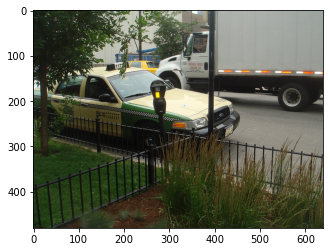


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000001.jpg

Inference caption output:
startseq truck is parked on the side of the road endseq


------------------------------
Inferrring image 2 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000016.jpg

Encoding shape = (2048,)


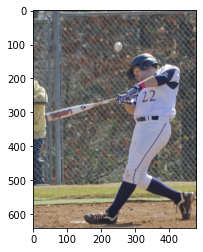


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000016.jpg

Inference caption output:
startseq baseball player swinging bat at ball endseq


------------------------------
Inferrring image 3 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000019.jpg

Encoding shape = (2048,)


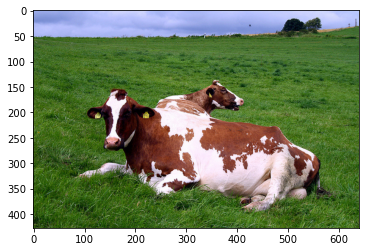


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000019.jpg

Inference caption output:
startseq cow is standing in the grass with cow endseq


------------------------------
Inferrring image 4 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000057.jpg

Encoding shape = (2048,)


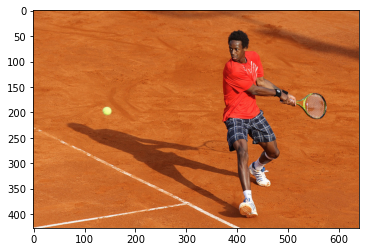


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000057.jpg

Inference caption output:
startseq man is playing tennis on tennis court endseq


------------------------------
Inferrring image 5 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000063.jpg

Encoding shape = (2048,)


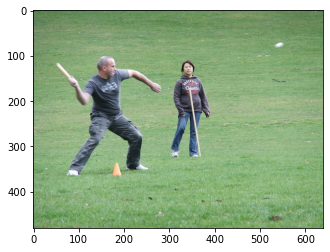


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000063.jpg

Inference caption output:
startseq two men playing game of frisbee in field endseq


------------------------------
Inferrring image 6 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000069.jpg

Encoding shape = (2048,)


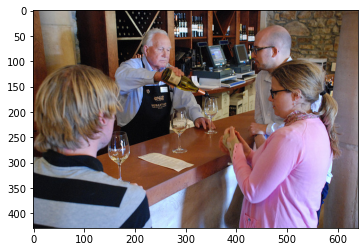


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000069.jpg

Inference caption output:
startseq group of people sitting around table with cake endseq


------------------------------
Inferrring image 7 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000080.jpg

Encoding shape = (2048,)


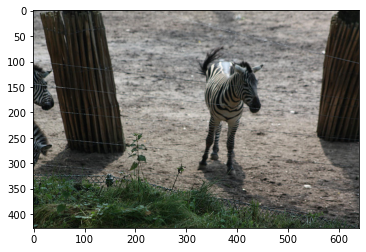


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000080.jpg

Inference caption output:
startseq zebra standing next to fence in the dirt endseq


------------------------------
Inferrring image 8 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000090.jpg

Encoding shape = (2048,)


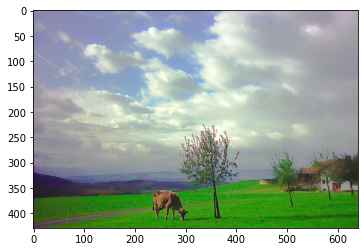


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000090.jpg

Inference caption output:
startseq two horses grazing in field of grass endseq


------------------------------
Inferrring image 9 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000106.jpg

Encoding shape = (2048,)


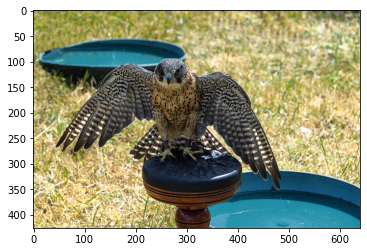


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000106.jpg

Inference caption output:
startseq bird sitting on top of wooden bench endseq


------------------------------
Inferrring image 10 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000108.jpg

Encoding shape = (2048,)


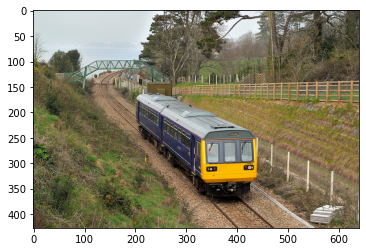


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000108.jpg

Inference caption output:
startseq train traveling down train tracks next to trees endseq


------------------------------
Inferrring image 11 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000128.jpg

Encoding shape = (2048,)


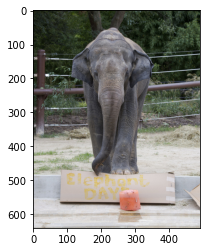


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000128.jpg

Inference caption output:
startseq an elephant standing in the dirt with an elephant endseq


------------------------------
Inferrring image 12 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000155.jpg

Encoding shape = (2048,)


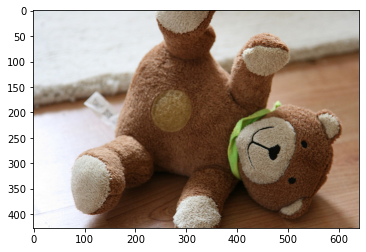


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000155.jpg

Inference caption output:
startseq teddy bear sitting on top of wooden table endseq


------------------------------
Inferrring image 13 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000161.jpg

Encoding shape = (2048,)


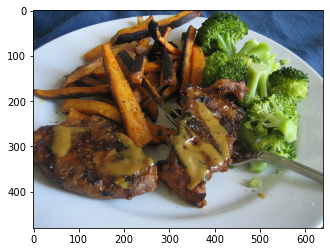


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000161.jpg

Inference caption output:
startseq plate of food with broccoli and broccoli endseq


------------------------------
Inferrring image 14 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000171.jpg

Encoding shape = (2048,)


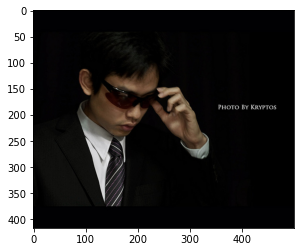


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000171.jpg

Inference caption output:
startseq man in suit and tie standing in front of microphone endseq


------------------------------
Inferrring image 15 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000178.jpg

Encoding shape = (2048,)


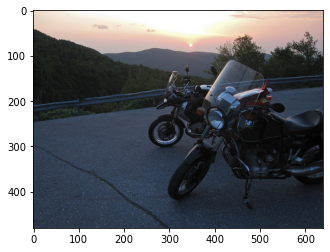


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000178.jpg

Inference caption output:
startseq motorcycle parked on the side of the road endseq


------------------------------
Inferrring image 16 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000180.jpg

Encoding shape = (2048,)


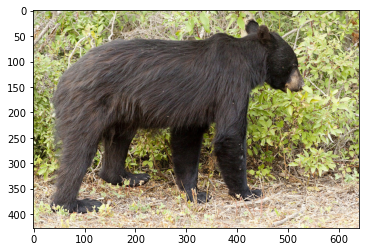


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000180.jpg

Inference caption output:
startseq black bear walking through the woods endseq


------------------------------
Inferrring image 17 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000183.jpg

Encoding shape = (2048,)


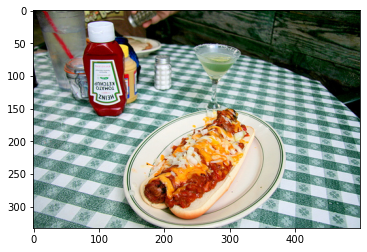


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000183.jpg

Inference caption output:
startseq plate of food with sandwich and cheese endseq


------------------------------
Inferrring image 18 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000188.jpg

Encoding shape = (2048,)


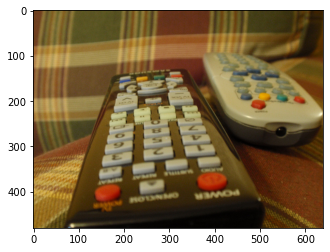


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000188.jpg

Inference caption output:
startseq remote control is on the table with remote control endseq


------------------------------
Inferrring image 19 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355341.jpg

Encoding shape = (2048,)


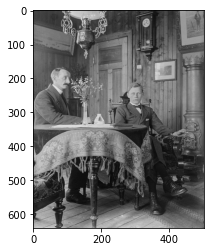


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355341.jpg

Inference caption output:
startseq man in black shirt and white shirt and white shirt and white shirt and white shirt endseq


------------------------------
Inferrring image 20 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355356.jpg

Encoding shape = (2048,)


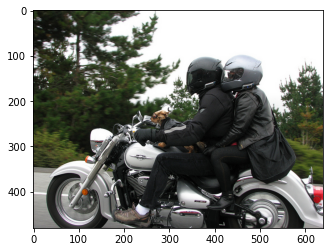


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355356.jpg

Inference caption output:
startseq man riding motorcycle on the side of road endseq


------------------------------
Inferrring image 21 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355358.jpg

Encoding shape = (2048,)


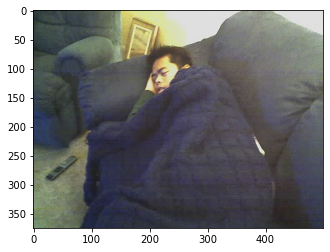


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355358.jpg

Inference caption output:
startseq man is sitting on couch with his head endseq


------------------------------
Inferrring image 22 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355364.jpg

Encoding shape = (2048,)


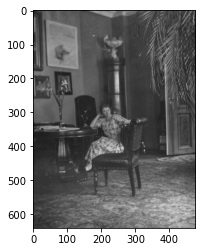


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355364.jpg

Inference caption output:
startseq man sitting on bench in front of an old building endseq


------------------------------
Inferrring image 23 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355378.jpg

Encoding shape = (2048,)


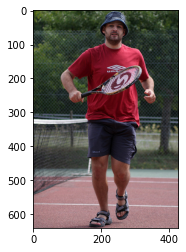


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355378.jpg

Inference caption output:
startseq man in baseball uniform throwing baseball endseq


------------------------------
Inferrring image 24 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355388.jpg

Encoding shape = (2048,)


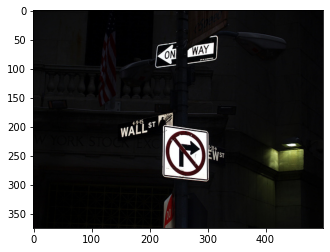


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355388.jpg

Inference caption output:
startseq street sign with street signs on it endseq


------------------------------
Inferrring image 25 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355390.jpg

Encoding shape = (2048,)


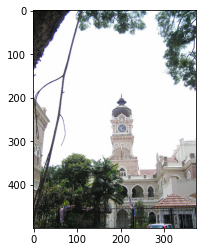


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355390.jpg

Inference caption output:
startseq large clock tower towering over the city endseq


------------------------------
Inferrring image 26 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355412.jpg

Encoding shape = (2048,)


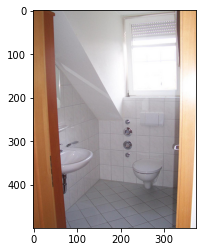


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355412.jpg

Inference caption output:
startseq bathroom with toilet and sink endseq


------------------------------
Inferrring image 27 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355443.jpg

Encoding shape = (2048,)


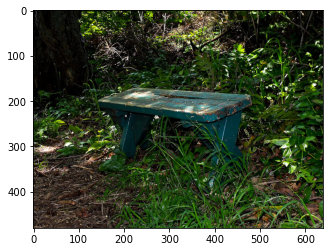


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355443.jpg

Inference caption output:
startseq bench with two green plants on it endseq


------------------------------
Inferrring image 28 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355449.jpg

Encoding shape = (2048,)


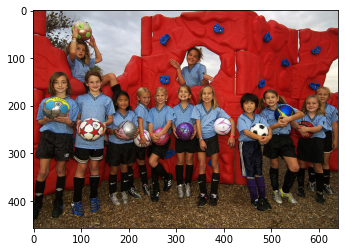


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355449.jpg

Inference caption output:
startseq group of people standing around with soccer balls endseq


------------------------------
Inferrring image 29 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355455.jpg

Encoding shape = (2048,)


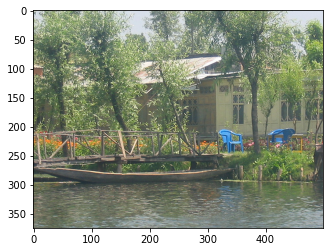


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355455.jpg

Inference caption output:
startseq boat is parked in the water with people in the background endseq


------------------------------
Inferrring image 30 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355502.jpg

Encoding shape = (2048,)


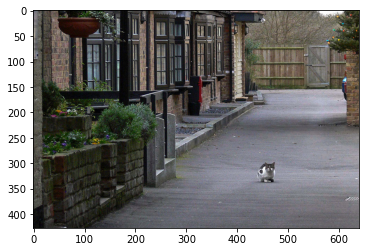


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355502.jpg

Inference caption output:
startseq dog sitting on the sidewalk next to fire hydrant endseq


------------------------------
Inferrring image 31 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355506.jpg

Encoding shape = (2048,)


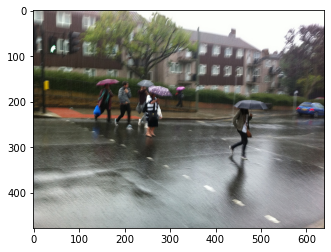


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355506.jpg

Inference caption output:
startseq man riding skateboard down street endseq


------------------------------
Inferrring image 32 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355524.jpg

Encoding shape = (2048,)


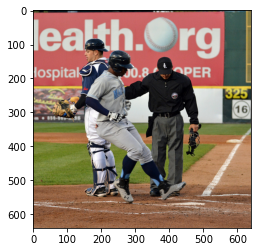


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355524.jpg

Inference caption output:
startseq baseball player swinging bat at ball endseq


------------------------------
Inferrring image 33 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355527.jpg

Encoding shape = (2048,)


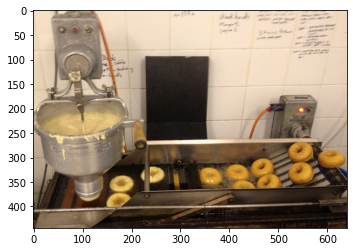


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355527.jpg

Inference caption output:
startseq an oven with an orange and white frosting endseq


------------------------------
Inferrring image 34 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355549.jpg

Encoding shape = (2048,)


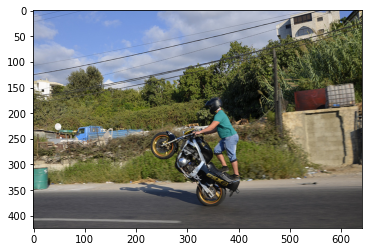


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355549.jpg

Inference caption output:
startseq man riding bike down the street endseq


------------------------------
Inferrring image 35 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355567.jpg

Encoding shape = (2048,)


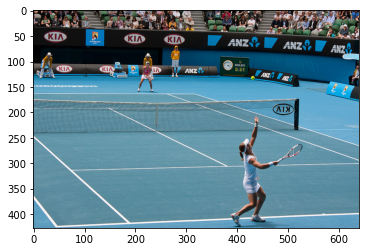


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355567.jpg

Inference caption output:
startseq tennis player is swinging tennis racket endseq


------------------------------
Inferrring image 36 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355572.jpg

Encoding shape = (2048,)


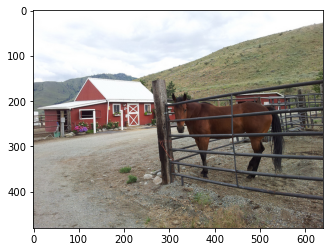


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355572.jpg

Inference caption output:
startseq horse is standing in the grass near fence endseq


------------------------------
Inferrring image 37 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355590.jpg

Encoding shape = (2048,)


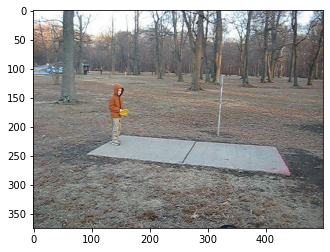


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355590.jpg

Inference caption output:
startseq man standing on the ground with frisbee endseq


------------------------------
Inferrring image 38 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355595.jpg

Encoding shape = (2048,)


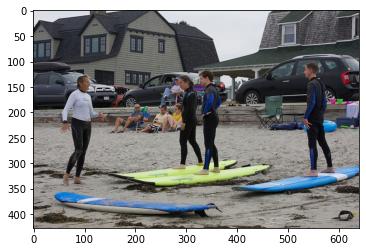


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355595.jpg

Inference caption output:
startseq man in bikini is standing on surfboard endseq


------------------------------
Inferrring image 39 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355616.jpg

Encoding shape = (2048,)


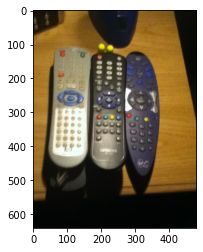


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355616.jpg

Inference caption output:
startseq remote control is on the table with remote control endseq


------------------------------
Inferrring image 40 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355626.jpg

Encoding shape = (2048,)


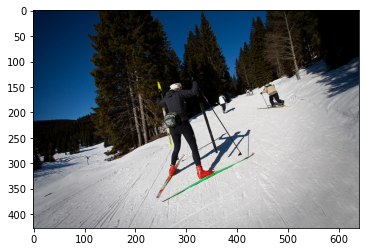


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355626.jpg

Inference caption output:
startseq man on skis is going down hill endseq


------------------------------
Inferrring image 41 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355631.jpg

Encoding shape = (2048,)


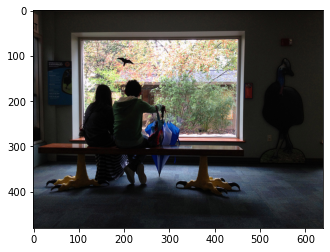


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355631.jpg

Inference caption output:
startseq man sitting on bench with his head on the back of him endseq


------------------------------
Inferrring image 42 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355633.jpg

Encoding shape = (2048,)


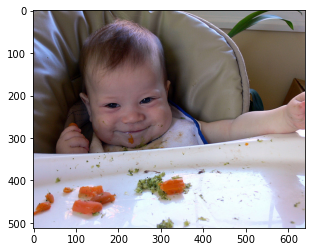


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355633.jpg

Inference caption output:
startseq baby sitting in chair with her head endseq


------------------------------
Inferrring image 43 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355634.jpg

Encoding shape = (2048,)


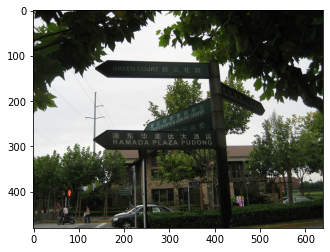


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355634.jpg

Inference caption output:
startseq street sign with street signs on it endseq


------------------------------
Inferrring image 44 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355644.jpg

Encoding shape = (2048,)


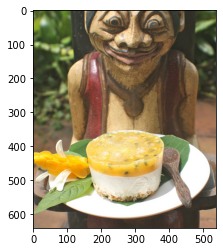


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000355644.jpg

Inference caption output:
startseq two plates of food on table with cup of coffee endseq


------------------------------
Inferrring image 45 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172760.jpg

Encoding shape = (2048,)


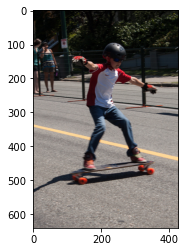


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172760.jpg

Inference caption output:
startseq man riding skateboard down street endseq


------------------------------
Inferrring image 46 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172766.jpg

Encoding shape = (2048,)


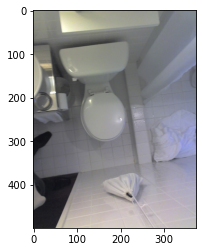


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172766.jpg

Inference caption output:
startseq bathroom with toilet and sink endseq


------------------------------
Inferrring image 47 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172768.jpg

Encoding shape = (2048,)


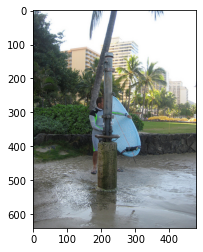


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172768.jpg

Inference caption output:
startseq boat is parked in the water near the water endseq


------------------------------
Inferrring image 48 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172772.jpg

Encoding shape = (2048,)


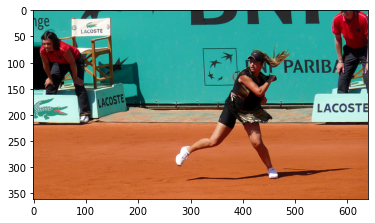


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172772.jpg

Inference caption output:
startseq man in white shirt playing tennis on court endseq


------------------------------
Inferrring image 49 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172775.jpg

Encoding shape = (2048,)


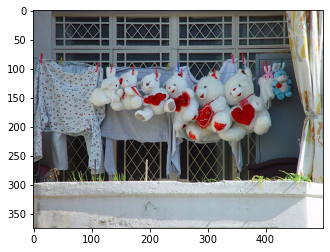


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172775.jpg

Inference caption output:
startseq teddy bear sitting on top of white chair endseq


------------------------------
Inferrring image 50 :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172802.jpg

Encoding shape = (2048,)


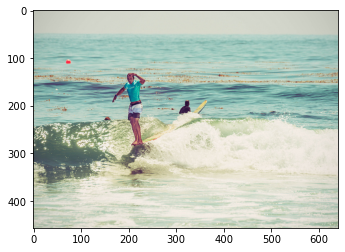


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000172802.jpg

Inference caption output:
startseq man riding surfboard on wave endseq



In [26]:
for idx, inF_test in enumerate(files2test):
    print(f"\n{'-' * 30}\nInferrring image {idx+1} :: {inF_test}\n")
    IMG_TO_INFER = inF_test
    infer_for_caption_one_image(IMG_TO_INFER, MAX_LENGTH_CAPTION, reloaded_RNN_decoder, _wordtoix = wordtoix, _ixtoword = ixtoword)

## Run inference - on just one random image of the Test2017 dataset (which has no captions)

In [27]:
IMG_JPG = '000000000080.jpg'
IMG_TO_INFER = '/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/' + IMG_JPG
print(f"{IMG_TO_INFER}")
print(f"{os.path.isfile(IMG_TO_INFER)}")

/media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000080.jpg
True


Encoding shape = (2048,)


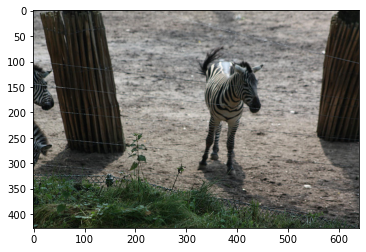


For image :: /media/rohit/DATA/EverythingD/01SRH-BDBA Acads/Thesis/StoryGenerator/Data/COCO_test2017_41k/test2017/000000000080.jpg

Inference caption output:
startseq two zebras are standing in the grass endseq



In [28]:
infer_for_caption_one_image(IMG_TO_INFER, MAX_LENGTH_CAPTION, reloaded_RNN_decoder, _wordtoix = wordtoix, _ixtoword = ixtoword)